In [37]:
# import libraries
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import math as m

#plotting
plt.rcParams.update({'font.size': 16})
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Gillepse direct method

In [38]:
# parameters (which we want to verify at the end)
beta = 0.0003
mu = 0.1

# outbreak time
t = 0

# initial populations
S = 999
I = 1
R = 0

data = np.array([t, S, I, R])

while I > 0:
    # pick r1, r2 from uniform distribution
    r1 = np.random.uniform(0,1)
    r2 = np.random.uniform(0,1)
    
    # time of next event (distributed exponentially)
    t += np.log(1/r1)/(beta*S*I + mu*I)
    
    # check if next event is infection or recovery
    if r2 < beta*S*I/(beta*S*I + mu*I):
        # infection
        S -= 1
        I += 1
                         
    else:
        #recovery
        I -= 1
        R += 1
        
    data = np.vstack((data,np.array([t, S, I, R])))

In [39]:
print(data)
print(np.shape(data))

[[  0.         999.           1.           0.        ]
 [  4.48720735 998.           2.           0.        ]
 [  5.78394539 997.           3.           0.        ]
 ...
 [ 94.08869906  60.           2.         938.        ]
 [104.13454659  60.           1.         939.        ]
 [109.34228203  60.           0.         940.        ]]
(1880, 4)


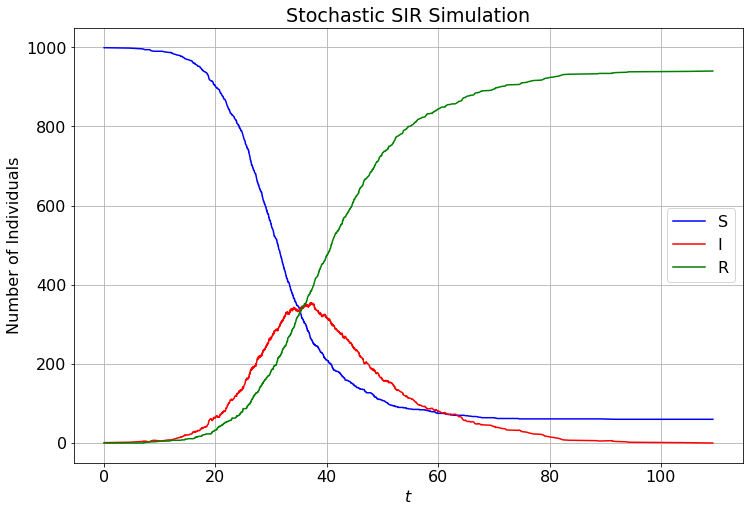

In [40]:
# plotting
fig = plt.figure(figsize=(12,8))

plt.plot(data[:,0], data[:,1], 'b', label='S')
plt.plot(data[:,0], data[:,2], 'r', label='I')
plt.plot(data[:,0], data[:,3], 'g', label='R')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('Number of Individuals')
plt.title('Stochastic SIR Simulation')
plt.grid()

In [41]:
# separate data into t, S, I, R
ts = data[:,0]
Ss = data[:,1]
Is = data[:,2]
Rs = data[:,3]

# parameter space
betas = np.linspace(0.0002, 0.0004, 21)
mus = np.linspace(0.05, 0.16, 21)

bgrid, ugrid = np.meshgrid(betas, mus)

In [42]:
# joint log-likelihood
logL = np.zeros((21,21))
L = np.zeros((21,21))

j = 0
for beta in betas:
    
    k = 0
    for mu in mus:
        
        for i in range(1,len(data)):

            if Is[i] - Is[i-1] == 1:
                # infection
                logL[j,k] += -(beta*Ss[i-1]*Is[i-1]+mu*Is[i-1])*(ts[i]-ts[i-1]) + np.log(beta*Ss[i-1]*Is[i-1])
        
            else:
                # recovery
                logL[j,k] += -(beta*Ss[i-1]*Is[i-1]+mu*Is[i-1])*(ts[i]-ts[i-1]) + np.log(mu*Is[i-1])

        L[j,k] = np.exp(logL[j,k])
        k += 1
    j += 1

/tmp/ipykernel_17205/2523533235.py:21: RuntimeWarning: overflow encountered in exp
  L[j,k] = np.exp(logL[j,k])


Text(0.5, 0.92, '$\\beta, \\mu$, Log-Likelihood surface')

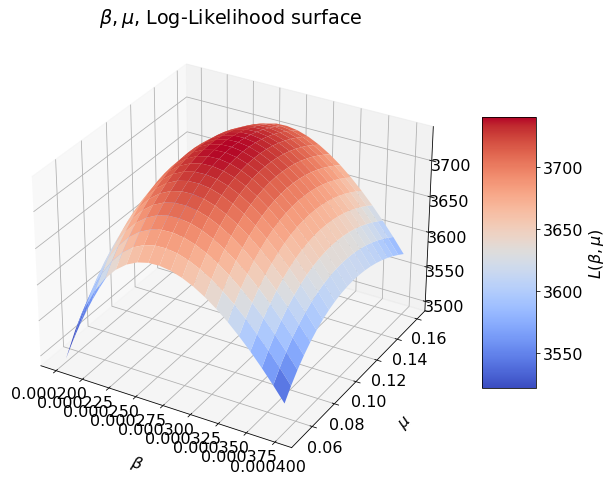

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(bgrid, ugrid, logL, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5, label='$L(\\beta, \mu)$')

ax.set_xlabel('$\\beta$', labelpad=20)
ax.set_ylabel('$\mu$', labelpad=20)
plt.title('$\\beta, \mu$, Log-Likelihood surface')

In [46]:
# checking beta and mu parameters which maximise the likelihood
n = logL.argmax()
i = int(np.floor(n/21))
j = int(n%21)

print(betas[i])
print(mus[i])

0.00031
0.1105


# Markov Chain Monte Carlo (MCMC)

In [47]:
def likelihood(data, beta, mu, scale):
    # separate data into t, S, I, R
    ts = data[:,0]
    Ss = data[:,1]
    Is = data[:,2]
    Rs = data[:,3]
    
    logL = 0
    for i in range(1,len(data)):

         if Is[i] - Is[i-1] == 1:
            # infection
            logL += -(beta*Ss[i-1]*Is[i-1]+mu*Is[i-1])*(ts[i]-ts[i-1]) + np.log(beta*Ss[i-1]*Is[i-1])
        
         else:
            # recovery
            logL += -(beta*Ss[i-1]*Is[i-1]+mu*Is[i-1])*(ts[i]-ts[i-1]) + np.log(mu*Is[i-1])

    return np.exp(logL - scale)

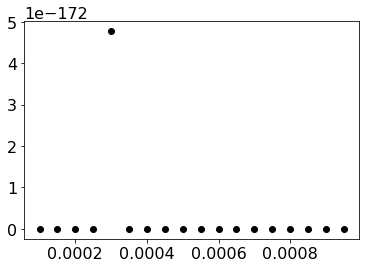

In [48]:
bs = np.arange(0.0001,0.001,0.00005)
plt.scatter(bs,likelihood(data, bs, mu, 4000),color='k')

In [49]:
N = 10000
betas = np.zeros((int(N/10),1))
betas[0] = 0.0005

# initial guess
beta = betas[0]
L = likelihood(data, beta, 0.1, 4000)

for i in range(1,N):
    
    # sampling new candidate guess
    betaguess = beta + np.random.uniform(-0.0001,0.0001)

    # calculate log-likelihood
    Ltrial = likelihood(data, betaguess, 0.1, 4000)
    
    # evaluate trial
    if Ltrial >= L:
        beta = betaguess
        L = Ltrial
    
    else:
        r = np.random.rand()
        
        if r < Ltrial/L:
            beta = betaguess
            L = Ltrial
    
    if i%10 == 0:
        betas[int(i/10)] = beta
    
    if i%200 == 0:
        print('i = ',i)

i =  200
i =  400
i =  600
i =  800
i =  1000
i =  1200
i =  1400
i =  1600
i =  1800
i =  2000
i =  2200
i =  2400
i =  2600
i =  2800
i =  3000
i =  3200
i =  3400
i =  3600
i =  3800
i =  4000
i =  4200
i =  4400
i =  4600
i =  4800
i =  5000
i =  5200
i =  5400
i =  5600
i =  5800
i =  6000
i =  6200
i =  6400
i =  6600
i =  6800
i =  7000
i =  7200
i =  7400
i =  7600
i =  7800
i =  8000
i =  8200
i =  8400
i =  8600
i =  8800
i =  9000
i =  9200
i =  9400
i =  9600
i =  9800


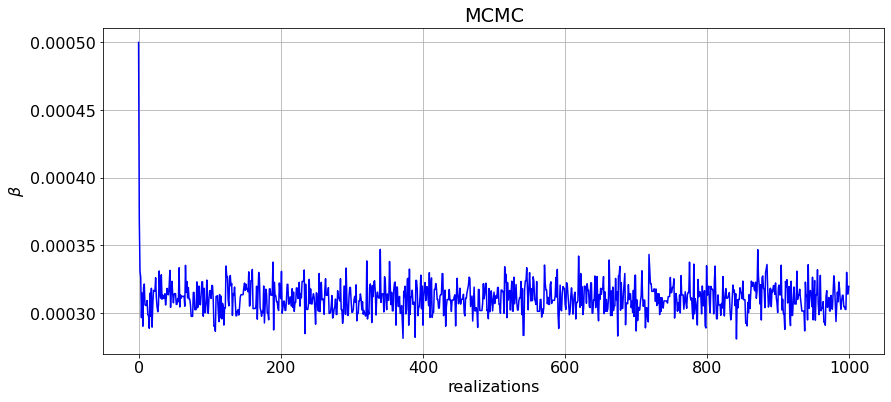

In [50]:
fig = plt.figure(figsize=(14,6))

plt.plot(range(len(betas)),betas,'b')
plt.xlabel('realizations')
plt.ylabel('$\\beta$')
plt.title('MCMC')
plt.grid()

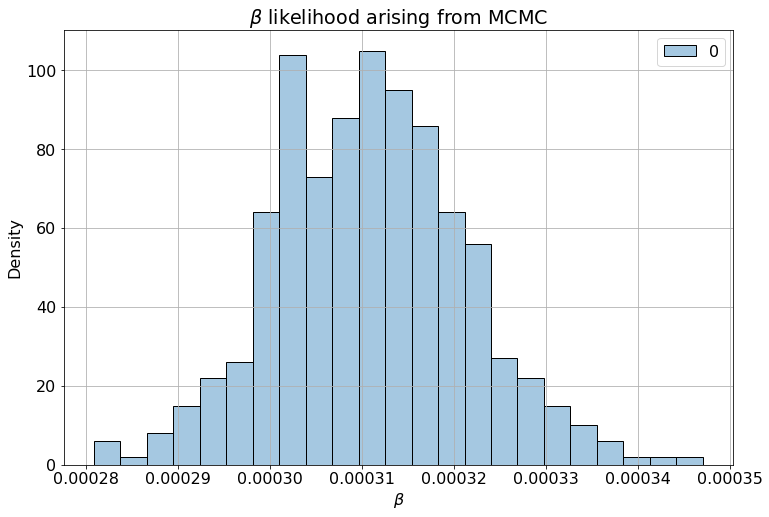

In [51]:
Betas = betas[int(N/100):]

fig = plt.figure(figsize=(12,8))
sns.histplot(Betas, color='k', alpha=0.4)
plt.xlabel('$\\beta$')
plt.ylabel('Density')
plt.title('$\\beta$ likelihood arising from MCMC')
plt.grid()

# Approximate Bayesian Computation (ABC)

In [65]:
# number infected at times t=0,10,20,...
Infected = []
tmax = int(data[:,0].max())

for i in range(0,tmax-10,10):
    Infected += [data[(data[:,0] >= i)&(data[:,0] < i+10)][-1,2]]

Infected = np.array(Infected)
Infected

array([  6.,  65., 264., 315., 159.,  81.,  42.,  16.,   5.,   2.])

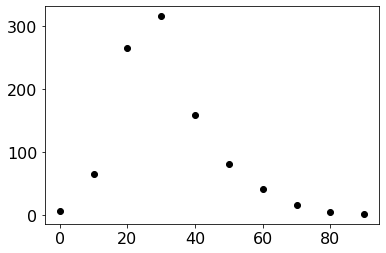

In [67]:
plt.scatter(np.arange(0,100,10), Infected, color='k')

In [68]:
def epi_model(beta, mu):
    # outbreak time
    t = 0
    # tmod increses with t and keeps track of increments of 10
    tmod = 0

    # initial populations
    S = 999
    I = 1
    R = 0

    data = np.array([I])
    
    while I > 0:
        # pick r1, r2 from uniform distribution
        r1 = np.random.uniform(0,1)
        r2 = np.random.uniform(0,1)
    
        # time of next event (distributed exponentially)
        dt = np.log(1/r1)/(beta*S*I + mu*I)
        t += dt
        tmod += dt
        
        if tmod > 10:
            data = np.vstack(( data, np.array([I]) ))
            tmod -= 10
            
        # check if next event is infection or recovery
        if r2 < beta*S*I/(beta*S*I + mu*I):
            # infection
            S -= 1
            I += 1
                         
        else:
            #recovery
            I -= 1
            R += 1
        
    return data

In [70]:
def chisq_criterion(simdata, realdata):
    measure = 0
    
    for i in range(np.minimum(len(simdata),len(realdata))):
        measure += (simdata[i] - realdata[i])**2/realdata[i]
    
    return measure

In [71]:
ABC = 200
Nsim = 200
eps = 50
valid_sims = []

for j in range(ABC):

    betatrial = 0.0003 + np.random.uniform(-0.0001,0.0001)

    for sims in range(Nsim):
        if chisq_criterion(epi_model(betatrial, mu), Infected) < 50:
            valid_sims += [betatrial]

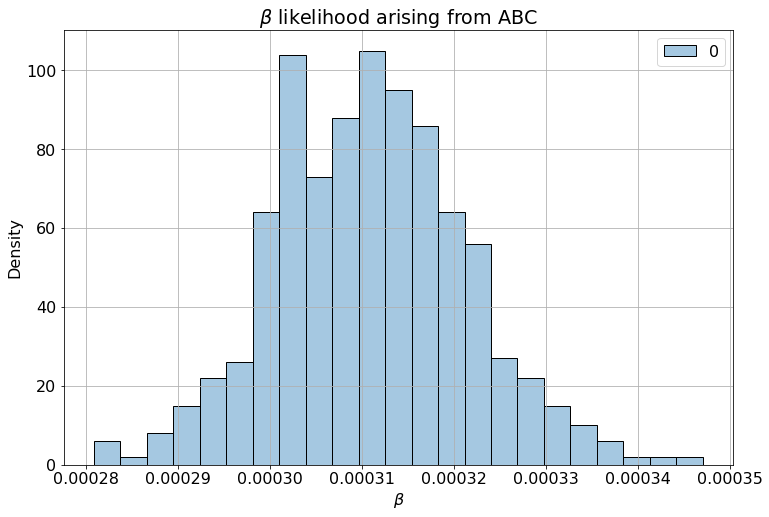

In [72]:
fig = plt.figure(figsize=(12,8))

sns.histplot(Betas, color='k', alpha=0.4)
plt.xlabel('$\\beta$')
plt.ylabel('Density')
plt.title('$\\beta$ likelihood arising from ABC')
plt.grid()